In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_only_conv_conv_5_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=8, strides=1, padding='valid', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=8*(2**(i+1)), strides=1, padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 9):
    model = build_1d_cnn_only_conv_conv_5_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15996, 8)          32        
_________________________________________________________________
activation (Activation)      (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5332, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 42656)             0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 42656)             170624    
_________________________________________________________________
dens

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_14 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_10 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 5328, 16)          64        
_________________________________________________________________
activation_11 (Activation)   (None, 5328, 16)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_35 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_28 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
batch_normalization_v1_36 (B (None, 5328, 16)          64        
_________________________________________________________________
activation_29 (Activation)   (None, 5328, 16)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7607 - acc: 0.2316
Epoch 00001: val_loss improved from inf to 2.51668, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_1_conv_checkpoint/001-2.5167.hdf5
36805/36805 [==============================] - 12s 313us/sample - loss: 2.7607 - acc: 0.2316 - val_loss: 2.5167 - val_acc: 0.2304
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0492 - acc: 0.3849
Epoch 00002: val_loss improved from 2.51668 to 2.49848, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_1_conv_checkpoint/002-2.4985.hdf5
36805/36805 [==============================] - 9s 252us/sample - loss: 2.0495 - acc: 0.3848 - val_loss: 2.4985 - val_acc: 0.3096
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.7090 - acc: 0.4774
Epoch 00003: val_loss did not improve from 2.49848
36805/368

Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3342 - acc: 0.9082
Epoch 00029: val_loss did not improve from 2.49848
36805/36805 [==============================] - 9s 253us/sample - loss: 0.3349 - acc: 0.9081 - val_loss: 3.8228 - val_acc: 0.2888
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3219 - acc: 0.9140
Epoch 00030: val_loss did not improve from 2.49848
36805/36805 [==============================] - 9s 257us/sample - loss: 0.3221 - acc: 0.9139 - val_loss: 3.8941 - val_acc: 0.2851
Epoch 31/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.3086 - acc: 0.9163
Epoch 00031: val_loss did not improve from 2.49848
36805/36805 [==============================] - 9s 249us/sample - loss: 0.3094 - acc: 0.9160 - val_loss: 3.9942 - val_acc: 0.2695
Epoch 32/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.3068 - acc: 0.9143
Epoch 00032: val_loss did not improve from 2.49848
36805/36805 [========

Epoch 59/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.1696 - acc: 0.9568
Epoch 00059: val_loss did not improve from 2.49848
36805/36805 [==============================] - 9s 247us/sample - loss: 0.1694 - acc: 0.9567 - val_loss: 4.6363 - val_acc: 0.2933
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1571 - acc: 0.9622
Epoch 00060: val_loss did not improve from 2.49848
36805/36805 [==============================] - 9s 246us/sample - loss: 0.1573 - acc: 0.9621 - val_loss: 4.7318 - val_acc: 0.2898
Epoch 61/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1533 - acc: 0.9622
Epoch 00061: val_loss did not improve from 2.49848
36805/36805 [==============================] - 9s 245us/sample - loss: 0.1533 - acc: 0.9622 - val_loss: 4.7492 - val_acc: 0.2926
Epoch 62/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1471 - acc: 0.9648
Epoch 00062: val_loss did not improve from 2.49848
36805/36805 [========

Epoch 89/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1062 - acc: 0.9740
Epoch 00089: val_loss did not improve from 2.49848
36805/36805 [==============================] - 9s 243us/sample - loss: 0.1080 - acc: 0.9738 - val_loss: 5.1433 - val_acc: 0.2886
Epoch 90/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1111 - acc: 0.9722
Epoch 00090: val_loss did not improve from 2.49848
36805/36805 [==============================] - 9s 240us/sample - loss: 0.1109 - acc: 0.9723 - val_loss: 5.1509 - val_acc: 0.2837
Epoch 91/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0986 - acc: 0.9767
Epoch 00091: val_loss did not improve from 2.49848
36805/36805 [==============================] - 9s 238us/sample - loss: 0.0989 - acc: 0.9766 - val_loss: 5.2089 - val_acc: 0.2807
Epoch 92/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1054 - acc: 0.9744
Epoch 00092: val_loss did not improve from 2.49848
36805/36805 [========

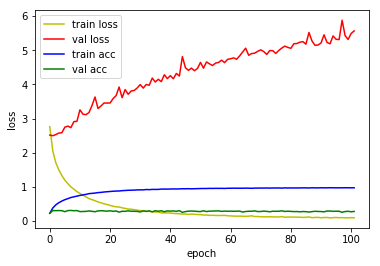

4815/4815 [==============================] - 1s 228us/sample - loss: 2.5952 - acc: 0.2735
Loss: 2.59520444057936 Accuracy: 0.27352026

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3130 - acc: 0.3191
Epoch 00001: val_loss improved from inf to 2.00829, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_2_conv_checkpoint/001-2.0083.hdf5
36805/36805 [==============================] - 14s 380us/sample - loss: 2.3125 - acc: 0.3190 - val_loss: 2.0083 - val_acc: 0.3690
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5752 - acc: 0.5185
Epoch 00002: val_loss improved from 2.00829 to 1.82772, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_2_conv_checkpoint/002-1.8277.hdf5
36805/36805 [==============================] - 12s 314us/sample - loss: 1.5757 - acc: 0.5184 - val_loss: 1.8277 - val_acc: 0.4577
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s -

Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0577 - acc: 0.9917
Epoch 00029: val_loss did not improve from 1.72196
36805/36805 [==============================] - 12s 313us/sample - loss: 0.0579 - acc: 0.9917 - val_loss: 2.6710 - val_acc: 0.4971
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0563 - acc: 0.9916
Epoch 00030: val_loss did not improve from 1.72196
36805/36805 [==============================] - 12s 314us/sample - loss: 0.0568 - acc: 0.9915 - val_loss: 2.7366 - val_acc: 0.4864
Epoch 31/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9938
Epoch 00031: val_loss did not improve from 1.72196
36805/36805 [==============================] - 12s 313us/sample - loss: 0.0491 - acc: 0.9939 - val_loss: 2.9385 - val_acc: 0.4766
Epoch 32/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9943
Epoch 00032: val_loss did not improve from 1.72196
36805/36805 [=====

Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9974
Epoch 00059: val_loss did not improve from 1.72196
36805/36805 [==============================] - 12s 313us/sample - loss: 0.0213 - acc: 0.9974 - val_loss: 3.3266 - val_acc: 0.4799
Epoch 60/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9963
Epoch 00060: val_loss did not improve from 1.72196
36805/36805 [==============================] - 11s 311us/sample - loss: 0.0243 - acc: 0.9963 - val_loss: 3.5309 - val_acc: 0.4610
Epoch 61/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9965
Epoch 00061: val_loss did not improve from 1.72196
36805/36805 [==============================] - 11s 311us/sample - loss: 0.0240 - acc: 0.9964 - val_loss: 3.3580 - val_acc: 0.4759
Epoch 62/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9965
Epoch 00062: val_loss did not improve from 1.72196
36805/36805 [=====

Epoch 89/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0142 - acc: 0.9979
Epoch 00089: val_loss did not improve from 1.72196
36805/36805 [==============================] - 12s 315us/sample - loss: 0.0143 - acc: 0.9979 - val_loss: 3.7664 - val_acc: 0.4661
Epoch 90/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0157 - acc: 0.9976
Epoch 00090: val_loss did not improve from 1.72196
36805/36805 [==============================] - 12s 318us/sample - loss: 0.0160 - acc: 0.9976 - val_loss: 3.7145 - val_acc: 0.4631
Epoch 91/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9969
Epoch 00091: val_loss did not improve from 1.72196
36805/36805 [==============================] - 12s 316us/sample - loss: 0.0191 - acc: 0.9968 - val_loss: 4.4437 - val_acc: 0.4312
Epoch 92/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9959
Epoch 00092: val_loss did not improve from 1.72196
36805/36805 [=====

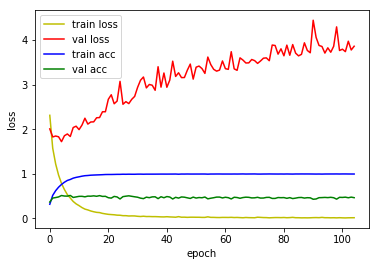

4815/4815 [==============================] - 1s 238us/sample - loss: 1.8383 - acc: 0.4665
Loss: 1.8382519834633309 Accuracy: 0.46645898

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.1143 - acc: 0.3638
Epoch 00001: val_loss improved from inf to 1.82696, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_3_conv_checkpoint/001-1.8270.hdf5
36805/36805 [==============================] - 17s 456us/sample - loss: 2.1134 - acc: 0.3640 - val_loss: 1.8270 - val_acc: 0.4144
Epoch 2/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.3911 - acc: 0.5698
Epoch 00002: val_loss improved from 1.82696 to 1.48652, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_3_conv_checkpoint/002-1.4865.hdf5
36805/36805 [==============================] - 14s 370us/sample - loss: 1.3912 - acc: 0.5700 - val_loss: 1.4865 - val_acc: 0.5511
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s

Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0511 - acc: 0.9942
Epoch 00028: val_loss did not improve from 1.34548
36805/36805 [==============================] - 14s 368us/sample - loss: 0.0513 - acc: 0.9941 - val_loss: 1.8511 - val_acc: 0.6147
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9939
Epoch 00029: val_loss did not improve from 1.34548
36805/36805 [==============================] - 14s 370us/sample - loss: 0.0493 - acc: 0.9939 - val_loss: 1.8649 - val_acc: 0.6161
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9951
Epoch 00030: val_loss did not improve from 1.34548
36805/36805 [==============================] - 13s 365us/sample - loss: 0.0453 - acc: 0.9951 - val_loss: 1.9468 - val_acc: 0.6175
Epoch 31/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9953
Epoch 00031: val_loss did not improve from 1.34548
36805/36805 [=====

Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9984
Epoch 00058: val_loss did not improve from 1.34548
36805/36805 [==============================] - 14s 372us/sample - loss: 0.0174 - acc: 0.9984 - val_loss: 2.3120 - val_acc: 0.6042
Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9977
Epoch 00059: val_loss did not improve from 1.34548
36805/36805 [==============================] - 13s 366us/sample - loss: 0.0185 - acc: 0.9976 - val_loss: 2.3249 - val_acc: 0.6000
Epoch 60/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0186 - acc: 0.9980
Epoch 00060: val_loss did not improve from 1.34548
36805/36805 [==============================] - 13s 363us/sample - loss: 0.0186 - acc: 0.9980 - val_loss: 2.2623 - val_acc: 0.6087
Epoch 61/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9980
Epoch 00061: val_loss did not improve from 1.34548
36805/36805 [=====

36736/36805 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9985
Epoch 00087: val_loss did not improve from 1.34548
36805/36805 [==============================] - 13s 366us/sample - loss: 0.0128 - acc: 0.9985 - val_loss: 2.4456 - val_acc: 0.6052
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9988
Epoch 00088: val_loss did not improve from 1.34548
36805/36805 [==============================] - 14s 371us/sample - loss: 0.0125 - acc: 0.9987 - val_loss: 2.5020 - val_acc: 0.6045
Epoch 89/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9977- ETA: 1s - loss: 0.
Epoch 00089: val_loss did not improve from 1.34548
36805/36805 [==============================] - 14s 369us/sample - loss: 0.0168 - acc: 0.9976 - val_loss: 2.5783 - val_acc: 0.5986
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9973
Epoch 00090: val_loss did not improve from 1.34548
36805/36805

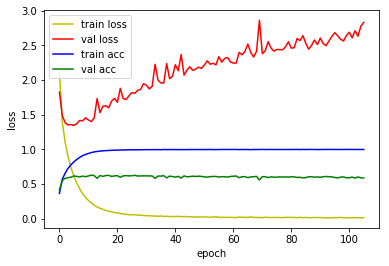

4815/4815 [==============================] - 1s 264us/sample - loss: 1.3988 - acc: 0.6004
Loss: 1.3988319131815545 Accuracy: 0.60041535

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.0018 - acc: 0.3888
Epoch 00001: val_loss improved from inf to 1.97506, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_4_conv_checkpoint/001-1.9751.hdf5
36805/36805 [==============================] - 21s 568us/sample - loss: 2.0012 - acc: 0.3891 - val_loss: 1.9751 - val_acc: 0.3811
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3355 - acc: 0.5917
Epoch 00002: val_loss improved from 1.97506 to 1.30175, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_4_conv_checkpoint/002-1.3018.hdf5
36805/36805 [==============================] - 16s 429us/sample - loss: 1.3355 - acc: 0.5917 - val_loss: 1.3018 - val_acc: 0.6091
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s

36736/36805 [============================>.] - ETA: 0s - loss: 0.0741 - acc: 0.9899
Epoch 00028: val_loss did not improve from 1.14976
36805/36805 [==============================] - 15s 420us/sample - loss: 0.0742 - acc: 0.9898 - val_loss: 1.4797 - val_acc: 0.6669
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0743 - acc: 0.9884
Epoch 00029: val_loss did not improve from 1.14976
36805/36805 [==============================] - 15s 420us/sample - loss: 0.0744 - acc: 0.9884 - val_loss: 1.4417 - val_acc: 0.6706
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0731 - acc: 0.9887
Epoch 00030: val_loss did not improve from 1.14976
36805/36805 [==============================] - 15s 420us/sample - loss: 0.0732 - acc: 0.9886 - val_loss: 1.4340 - val_acc: 0.6688
Epoch 31/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9911
Epoch 00031: val_loss did not improve from 1.14976
36805/36805 [==================

Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9958
Epoch 00058: val_loss did not improve from 1.14976
36805/36805 [==============================] - 15s 419us/sample - loss: 0.0296 - acc: 0.9958 - val_loss: 1.7674 - val_acc: 0.6580
Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9944
Epoch 00059: val_loss did not improve from 1.14976
36805/36805 [==============================] - 16s 425us/sample - loss: 0.0318 - acc: 0.9944 - val_loss: 1.7627 - val_acc: 0.6774
Epoch 60/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9943
Epoch 00060: val_loss did not improve from 1.14976
36805/36805 [==============================] - 16s 423us/sample - loss: 0.0341 - acc: 0.9942 - val_loss: 1.7708 - val_acc: 0.6615
Epoch 61/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0304 - acc: 0.9957
Epoch 00061: val_loss did not improve from 1.14976
36805/36805 [=====

Epoch 88/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9971
Epoch 00088: val_loss did not improve from 1.14976
36805/36805 [==============================] - 16s 425us/sample - loss: 0.0196 - acc: 0.9971 - val_loss: 1.9036 - val_acc: 0.6639
Epoch 89/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9965
Epoch 00089: val_loss did not improve from 1.14976
36805/36805 [==============================] - 16s 423us/sample - loss: 0.0217 - acc: 0.9965 - val_loss: 1.8996 - val_acc: 0.6681
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9976
Epoch 00090: val_loss did not improve from 1.14976
36805/36805 [==============================] - 16s 425us/sample - loss: 0.0192 - acc: 0.9976 - val_loss: 1.8892 - val_acc: 0.6706
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9976
Epoch 00091: val_loss did not improve from 1.14976
36805/36805 [=====

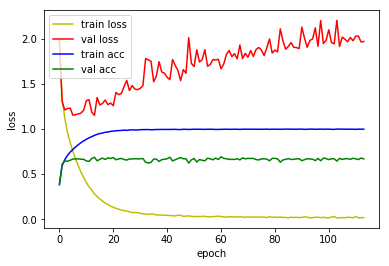

4815/4815 [==============================] - 1s 289us/sample - loss: 1.2236 - acc: 0.6644
Loss: 1.223611071424197 Accuracy: 0.66438216

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8214 - acc: 0.4364
Epoch 00001: val_loss improved from inf to 1.67338, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_5_conv_checkpoint/001-1.6734.hdf5
36805/36805 [==============================] - 25s 675us/sample - loss: 1.8215 - acc: 0.4364 - val_loss: 1.6734 - val_acc: 0.4279
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1892 - acc: 0.6377
Epoch 00002: val_loss improved from 1.67338 to 1.12687, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_5_conv_checkpoint/002-1.1269.hdf5
36805/36805 [==============================] - 16s 448us/sample - loss: 1.1894 - acc: 0.6377 - val_loss: 1.1269 - val_acc: 0.6573
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9873
Epoch 00027: val_loss did not improve from 0.72262
36805/36805 [==============================] - 17s 462us/sample - loss: 0.0745 - acc: 0.9873 - val_loss: 1.1511 - val_acc: 0.7312
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0696 - acc: 0.9886
Epoch 00028: val_loss did not improve from 0.72262
36805/36805 [==============================] - 17s 463us/sample - loss: 0.0698 - acc: 0.9886 - val_loss: 0.8190 - val_acc: 0.8083
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0685 - acc: 0.9883
Epoch 00029: val_loss did not improve from 0.72262
36805/36805 [==============================] - 17s 461us/sample - loss: 0.0686 - acc: 0.9882 - val_loss: 0.9057 - val_acc: 0.7815
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0647 - acc: 0.9894
Epoch 00030: val_loss did not improve from 0.72262
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9940
Epoch 00057: val_loss did not improve from 0.72262
36805/36805 [==============================] - 17s 457us/sample - loss: 0.0340 - acc: 0.9940 - val_loss: 1.1029 - val_acc: 0.7845
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9978
Epoch 00058: val_loss did not improve from 0.72262
36805/36805 [==============================] - 17s 458us/sample - loss: 0.0202 - acc: 0.9978 - val_loss: 0.9062 - val_acc: 0.8027
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9946
Epoch 00059: val_loss did not improve from 0.72262
36805/36805 [==============================] - 17s 454us/sample - loss: 0.0297 - acc: 0.9946 - val_loss: 0.9891 - val_acc: 0.7980
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0311 - acc: 0.9944
Epoch 00060: val_loss did not improve from 0.72262
36805/36805 [=====

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9967
Epoch 00087: val_loss did not improve from 0.72262
36805/36805 [==============================] - 17s 450us/sample - loss: 0.0210 - acc: 0.9966 - val_loss: 1.0026 - val_acc: 0.8102
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9965
Epoch 00088: val_loss did not improve from 0.72262
36805/36805 [==============================] - 16s 447us/sample - loss: 0.0210 - acc: 0.9964 - val_loss: 1.1040 - val_acc: 0.7950
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9933
Epoch 00089: val_loss did not improve from 0.72262
36805/36805 [==============================] - 16s 445us/sample - loss: 0.0328 - acc: 0.9932 - val_loss: 0.9985 - val_acc: 0.8185
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9961
Epoch 00090: val_loss did not improve from 0.72262
36805/36805 [=====

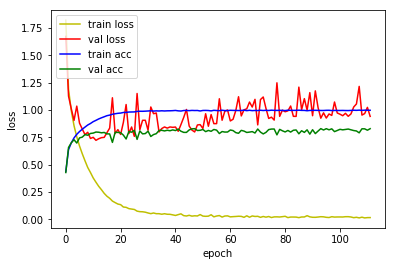

4815/4815 [==============================] - 2s 347us/sample - loss: 0.8096 - acc: 0.7674
Loss: 0.8095521053173584 Accuracy: 0.7673936

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7542 - acc: 0.4614
Epoch 00001: val_loss improved from inf to 1.35724, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_6_conv_checkpoint/001-1.3572.hdf5
36805/36805 [==============================] - 29s 801us/sample - loss: 1.7544 - acc: 0.4613 - val_loss: 1.3572 - val_acc: 0.5851
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0309 - acc: 0.6893
Epoch 00002: val_loss improved from 1.35724 to 0.93583, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_6_conv_checkpoint/002-0.9358.hdf5
36805/36805 [==============================] - 19s 504us/sample - loss: 1.0310 - acc: 0.6893 - val_loss: 0.9358 - val_acc: 0.7251
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9924
Epoch 00025: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 490us/sample - loss: 0.0444 - acc: 0.9924 - val_loss: 0.4832 - val_acc: 0.8747
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9902
Epoch 00026: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 492us/sample - loss: 0.0484 - acc: 0.9902 - val_loss: 0.3901 - val_acc: 0.8961
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9936
Epoch 00027: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 495us/sample - loss: 0.0363 - acc: 0.9936 - val_loss: 0.4786 - val_acc: 0.8877
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9907
Epoch 00028: val_loss did not improve from 0.35071
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9910
Epoch 00055: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 489us/sample - loss: 0.0367 - acc: 0.9910 - val_loss: 0.4200 - val_acc: 0.9001
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9979
Epoch 00056: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 491us/sample - loss: 0.0132 - acc: 0.9979 - val_loss: 0.3867 - val_acc: 0.9103
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9987
Epoch 00057: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 493us/sample - loss: 0.0107 - acc: 0.9988 - val_loss: 0.3963 - val_acc: 0.9089
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9985
Epoch 00058: val_loss did not improve from 0.35071
36805/36805 [=====

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9969
Epoch 00085: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 496us/sample - loss: 0.0149 - acc: 0.9969 - val_loss: 0.4298 - val_acc: 0.9110
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9967
Epoch 00086: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 497us/sample - loss: 0.0146 - acc: 0.9967 - val_loss: 0.5531 - val_acc: 0.8854
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9963
Epoch 00087: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 498us/sample - loss: 0.0145 - acc: 0.9963 - val_loss: 0.4211 - val_acc: 0.9057
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9994
Epoch 00088: val_loss did not improve from 0.35071
36805/36805 [=====

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9968
Epoch 00115: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 492us/sample - loss: 0.0124 - acc: 0.9968 - val_loss: 0.4547 - val_acc: 0.9108
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9990
Epoch 00116: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 486us/sample - loss: 0.0060 - acc: 0.9990 - val_loss: 0.5192 - val_acc: 0.9029
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9976
Epoch 00117: val_loss did not improve from 0.35071
36805/36805 [==============================] - 18s 490us/sample - loss: 0.0107 - acc: 0.9975 - val_loss: 0.4789 - val_acc: 0.9040
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9960
Epoch 00118: val_loss did not improve from 0.35071
36805/36805 [=

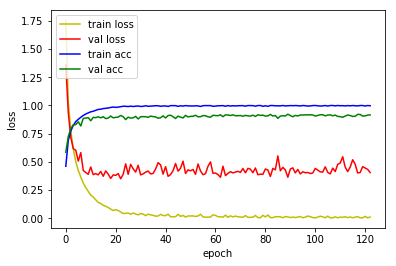

4815/4815 [==============================] - 2s 389us/sample - loss: 0.4269 - acc: 0.8860
Loss: 0.42686391343456437 Accuracy: 0.8859813

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3252 - acc: 0.5886
Epoch 00001: val_loss improved from inf to 1.17442, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_7_conv_checkpoint/001-1.1744.hdf5
36805/36805 [==============================] - 35s 955us/sample - loss: 1.3252 - acc: 0.5886 - val_loss: 1.1744 - val_acc: 0.6259
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6259 - acc: 0.8135
Epoch 00002: val_loss improved from 1.17442 to 0.52369, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_7_conv_checkpoint/002-0.5237.hdf5
36805/36805 [==============================] - 20s 543us/sample - loss: 0.6260 - acc: 0.8134 - val_loss: 0.5237 - val_acc: 0.8418
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9946
Epoch 00026: val_loss did not improve from 0.20956
36805/36805 [==============================] - 20s 542us/sample - loss: 0.0233 - acc: 0.9946 - val_loss: 0.2675 - val_acc: 0.9299
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9965
Epoch 00027: val_loss did not improve from 0.20956
36805/36805 [==============================] - 20s 534us/sample - loss: 0.0175 - acc: 0.9965 - val_loss: 0.2733 - val_acc: 0.9238
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9967
Epoch 00028: val_loss did not improve from 0.20956
36805/36805 [==============================] - 20s 540us/sample - loss: 0.0162 - acc: 0.9967 - val_loss: 0.2592 - val_acc: 0.9352
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9944
Epoch 00029: val_loss did not improve from 0.20956
36805/36805 [=====

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0042 - acc: 0.9993
Epoch 00056: val_loss did not improve from 0.20956
36805/36805 [==============================] - 20s 538us/sample - loss: 0.0042 - acc: 0.9993 - val_loss: 0.2463 - val_acc: 0.9390
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9996
Epoch 00057: val_loss did not improve from 0.20956
36805/36805 [==============================] - 20s 545us/sample - loss: 0.0029 - acc: 0.9996 - val_loss: 0.3239 - val_acc: 0.9292
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9964
Epoch 00058: val_loss did not improve from 0.20956
36805/36805 [==============================] - 20s 536us/sample - loss: 0.0134 - acc: 0.9964 - val_loss: 0.3047 - val_acc: 0.9336
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9986
Epoch 00059: val_loss did not improve from 0.20956
36805/36805 [=====

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9987
Epoch 00086: val_loss did not improve from 0.20956
36805/36805 [==============================] - 19s 524us/sample - loss: 0.0057 - acc: 0.9987 - val_loss: 0.2420 - val_acc: 0.9460
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9985
Epoch 00087: val_loss did not improve from 0.20956
36805/36805 [==============================] - 20s 538us/sample - loss: 0.0062 - acc: 0.9985 - val_loss: 0.3599 - val_acc: 0.9248
Epoch 88/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9977
Epoch 00088: val_loss did not improve from 0.20956
36805/36805 [==============================] - 20s 540us/sample - loss: 0.0093 - acc: 0.9977 - val_loss: 0.2889 - val_acc: 0.9331
Epoch 89/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9970
Epoch 00089: val_loss did not improve from 0.20956
36805/36805 [=====

Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9992
Epoch 00116: val_loss did not improve from 0.20956
36805/36805 [==============================] - 19s 527us/sample - loss: 0.0032 - acc: 0.9992 - val_loss: 0.2246 - val_acc: 0.9476
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0010 - acc: 0.9998
Epoch 00117: val_loss did not improve from 0.20956
36805/36805 [==============================] - 19s 525us/sample - loss: 0.0012 - acc: 0.9997 - val_loss: 0.2360 - val_acc: 0.9455
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9970
Epoch 00118: val_loss did not improve from 0.20956
36805/36805 [==============================] - 19s 528us/sample - loss: 0.0096 - acc: 0.9970 - val_loss: 0.2423 - val_acc: 0.9481
Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.9998
Epoch 00119: val_loss did not improve from 0.20956
36805/36805 [=

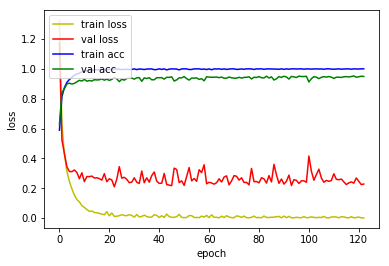

4815/4815 [==============================] - 2s 392us/sample - loss: 0.2964 - acc: 0.9167
Loss: 0.29638943925793915 Accuracy: 0.9167186

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9832 - acc: 0.6940
Epoch 00001: val_loss improved from inf to 0.70580, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_8_conv_checkpoint/001-0.7058.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.9833 - acc: 0.6940 - val_loss: 0.7058 - val_acc: 0.7747
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4011 - acc: 0.8733
Epoch 00002: val_loss improved from 0.70580 to 0.39309, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_8_conv_checkpoint/002-0.3931.hdf5
36805/36805 [==============================] - 22s 593us/sample - loss: 0.4012 - acc: 0.8733 - val_loss: 0.3931 - val_acc: 0.8749
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9968
Epoch 00027: val_loss did not improve from 0.23412
36805/36805 [==============================] - 22s 595us/sample - loss: 0.0134 - acc: 0.9967 - val_loss: 0.2781 - val_acc: 0.9324
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9936
Epoch 00028: val_loss improved from 0.23412 to 0.23071, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_BN_8_conv_checkpoint/028-0.2307.hdf5
36805/36805 [==============================] - 22s 598us/sample - loss: 0.0212 - acc: 0.9936 - val_loss: 0.2307 - val_acc: 0.9390
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9989
Epoch 00029: val_loss did not improve from 0.23071
36805/36805 [==============================] - 22s 596us/sample - loss: 0.0054 - acc: 0.9989 - val_loss: 0.2370 - val_acc: 0.9401
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9960
Epoch 00056: val_loss did not improve from 0.22515
36805/36805 [==============================] - 22s 587us/sample - loss: 0.0156 - acc: 0.9960 - val_loss: 0.2303 - val_acc: 0.9434
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0061 - acc: 0.9982
Epoch 00057: val_loss did not improve from 0.22515
36805/36805 [==============================] - 22s 586us/sample - loss: 0.0061 - acc: 0.9982 - val_loss: 0.2854 - val_acc: 0.9376
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9965
Epoch 00058: val_loss did not improve from 0.22515
36805/36805 [==============================] - 22s 589us/sample - loss: 0.0113 - acc: 0.9965 - val_loss: 0.2843 - val_acc: 0.9352
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9984
Epoch 00059: val_loss did not improve from 0.22515
36805/36805 [=====

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9977
Epoch 00085: val_loss did not improve from 0.21497
36805/36805 [==============================] - 22s 588us/sample - loss: 0.0075 - acc: 0.9977 - val_loss: 0.3712 - val_acc: 0.9241
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9961
Epoch 00086: val_loss did not improve from 0.21497
36805/36805 [==============================] - 22s 590us/sample - loss: 0.0126 - acc: 0.9961 - val_loss: 0.3487 - val_acc: 0.9297
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0052 - acc: 0.9986
Epoch 00087: val_loss did not improve from 0.21497
36805/36805 [==============================] - 22s 588us/sample - loss: 0.0052 - acc: 0.9986 - val_loss: 0.2497 - val_acc: 0.9509
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9987
Epoch 00088: val_loss did not improve from 0.21497
36805/36805 [=====

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 0.9998
Epoch 00115: val_loss did not improve from 0.21497
36805/36805 [==============================] - 22s 592us/sample - loss: 0.0011 - acc: 0.9998 - val_loss: 0.2976 - val_acc: 0.9432
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9975
Epoch 00116: val_loss did not improve from 0.21497
36805/36805 [==============================] - 22s 588us/sample - loss: 0.0076 - acc: 0.9975 - val_loss: 0.3773 - val_acc: 0.9273
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9982
Epoch 00117: val_loss did not improve from 0.21497
36805/36805 [==============================] - 22s 592us/sample - loss: 0.0057 - acc: 0.9982 - val_loss: 0.2945 - val_acc: 0.9415
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0043 - acc: 0.9986
Epoch 00118: val_loss did not improve from 0.21497
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9971
Epoch 00144: val_loss did not improve from 0.21497
36805/36805 [==============================] - 22s 587us/sample - loss: 0.0113 - acc: 0.9971 - val_loss: 0.2679 - val_acc: 0.9506
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9981
Epoch 00145: val_loss did not improve from 0.21497
36805/36805 [==============================] - 22s 587us/sample - loss: 0.0079 - acc: 0.9981 - val_loss: 0.2637 - val_acc: 0.9492
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9988
Epoch 00146: val_loss did not improve from 0.21497
36805/36805 [==============================] - 22s 586us/sample - loss: 0.0045 - acc: 0.9988 - val_loss: 0.2493 - val_acc: 0.9509
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 9.2699e-04 - acc: 0.9998
Epoch 00147: val_loss did not improve from 0.21497
36805/36805 [===========

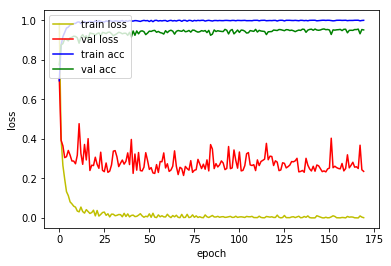

4815/4815 [==============================] - 2s 444us/sample - loss: 0.3343 - acc: 0.9238
Loss: 0.33425746609767276 Accuracy: 0.92377985



In [10]:
for i in range(1, 9):
    base = '1D_CNN_only_conv_conv_5_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_only_conv_conv_5_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_only_conv_conv_5_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_only_conv_conv_5_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_44 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_36 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 42656)             0         
_________________________________________________________________
batch_normalization_v1_45 (B (None, 42656)             170624    
_________________________________________________________________
dense_8 (Dense)              (None,

4815/4815 [==============================] - 2s 426us/sample - loss: 1.2236 - acc: 0.6644
Loss: 1.223611071424197 Accuracy: 0.66438216

1D_CNN_only_conv_conv_5_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_58 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_46 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
batch_normalization_v1_59 (B (No

4815/4815 [==============================] - 2s 489us/sample - loss: 0.2964 - acc: 0.9167
Loss: 0.29638943925793915 Accuracy: 0.9167186

1D_CNN_only_conv_conv_5_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_79 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_64 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
batch_normalization_v1_80 (B (N